In [12]:
library(pheatmap)  
library(tidyverse)
library(RColorBrewer)
library(viridis)
library(reshape2)
library( org.Hs.eg.db ) 
library(AnnotationDbi) 
library(Biobase)
library(limma)
library(tximport)

library(stringr)
library(GenomicRanges)
library(ChIPseeker)
library(TxDb.Hsapiens.UCSC.hg19.knownGene)


library(Rtsne)
library(caret)  
library(clusterProfiler)
library(pheatmap)
library(ReactomePA)
library(annotate)
library(seqinr)
# library(qlcMatrix)


In [13]:
save_pheatmap_png <- function(x, filename, width=1200, height=1000, res = 200) {
  png(filename, width = width, height = height, res = res)
  grid::grid.newpage()
  grid::grid.draw(x$gtable)
  dev.off()
}


In [14]:

createSig <- function (data, metadata, col_sel,tissue=TRUE, logFC_thres=.1, p_thres=0.05,max_return = -1) {
    # Differential expression analysis with limmma
    # This function takes in a target
    # Output is a result table of differential expression analysis for target vs control

    # load data and preprocess
    if (tissue){
    metadata = metadata %>% 
        mutate(label = if_else(tissues==col_sel, 'target', 'control'))
    }
    else{
         metadata = metadata %>% 
        mutate(label = if_else(group==col_sel, 'target', 'control'))
    }

    # set up the design
    labels <- factor(metadata$label)
    design <- model.matrix(~ labels + 1)
    colnames(design) <- levels(labels)
    rownames(design) <- metadata$tissue

    # proceed with analysis
    fit <- lmFit(data, design)
    fit <- eBayes(fit, trend=TRUE)
    tT = topTable(fit, coef=ncol(design),adjust="fdr", sort.by="p", number=Inf)
    tT$gene = rownames(tT)
    tT = na.omit(tT)
    tT_filt = tT[tT$logFC>logFC_thres  & tT$adj.P.Val<p_thres,]
    tT_filt = tT_filt%>% arrange(adj.P.Val)%>% arrange(desc(logFC))
    print(dim(tT_filt))
    if( max_return >0){
        tT_filt = tT_filt[1:min(max_return, dim(tT_filt)[1]),]
    }
  return(tT_filt)
}

In [15]:
save_prefix = '../data/processed/fig1/hichip/'

In [48]:
tissue_loop_df = read.csv(paste0(save_prefix,'tissue_loop_df.csv'),row.names=1)

In [49]:
tissue_loop_df_log = log2(tissue_loop_df+1e-2)
tissue_loop_df_norm = as.data.frame(scale(tissue_loop_df_log, center = TRUE, scale = TRUE))


In [52]:
annon_df = read.csv( '../data/processed/fig1/rna/annon_df.csv',row.names=1)

In [53]:
normal_tissue_order = c('GM12878',
                        'Astrocytes', 'Melanocytes',
                         'Colon',  'Esophageal','Ovarian', 'Pancreas','Renal','Thyroid',
                        'Airway','Bladder','GDSD0','GDSD3','GDSD6','HMEC','Prostate','Uterine')


In [54]:
dim(tissue_loop_df)
head(tissue_loop_df)

[1] 1142713      17

,Airway,Astrocytes,Bladder,Colon,Esophageal,GDSD0,GDSD3,GDSD6,GM12878,HMEC,Melanocytes,Ovarian,Pancreas,Prostate,Renal,Thyroid,Uterine
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr10_100020000_100025000::chr10_100055000_100060000,13,0,0,0,0,0,0,0,0,14,0,0,0,0,0,0,0
chr10_100020000_100025000::chr10_100065000_100070000,13,17,0,2825,2421,15,0,16,0,1315,0,1523,1619,21,2021,2423,33
chr10_100025000_100030000::chr10_100055000_100060000,14,0,0,0,2516,0,0,0,0,0,0,18,23,0,16,0,0
chr10_100025000_100030000::chr10_100065000_100070000,11,22,0,2622,3336,0,0,18,0,0,0,4221,3350,1816,1937,2435,0
chr10_101150000_101155000::chr10_101180000_101185000,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19,0
chr10_101150000_101155000::chr10_101190000_101195000,1529,26,20,4931,3031,42,19,0,0,27,0,4244,2624,2464,2932,3740,6627


In [55]:
metadata = annon_df
metadata$tissue = rownames(annon_df)
metadata$group = as.character(metadata$group)

metadata['Astrocytes','group'] = 'blue1'
metadata['Melanocytes','group'] = 'blue2'
metadata$group = as.factor(metadata$group)
metadata

,group,tissue
,<fct>,<chr>
Airway,purple,Airway
Astrocytes,blue1,Astrocytes
Bladder,purple,Bladder
Colon,green,Colon
Esophageal,green,Esophageal
GDSD0,purple,GDSD0
GDSD3,purple,GDSD3
GDSD6,purple,GDSD6
GM12878,grey,GM12878


In [56]:
#### per group


sig_loop_list = list()
sig_loop_combined = c()
for (group in c("grey","blue1", 'blue2', "green","purple")){
    tT_filt = createSig(tissue_loop_df_log, metadata,  col_sel=group,tissue=FALSE,max_return = 10000)
    print(group)
    print(dim(tT_filt))
    sig_loop_list[[group]] = tT_filt$gene
    sig_loop_combined = c(sig_loop_combined,tT_filt$gene)
}

[1] 100154      7
[1] "grey"
[1] 10000     7
[1] 81381     7
[1] "blue1"
[1] 10000     7
[1] 17341     7
[1] "blue2"
[1] 10000     7
[1] 26980     7
[1] "green"
[1] 10000     7
[1] 12010     7
[1] "purple"
[1] 10000     7


In [57]:
length(sig_loop_combined)
# sig_genes_combined = unique(sort(sig_genes_combined))
sig_loop_combined = unique(sig_loop_combined)
length(sig_loop_combined)

[1] 50000

[1] 49999

In [58]:
tissue_loop_sig = tissue_loop_df_norm[sig_loop_combined,normal_tissue_order]
# rna_df_tissue_norm_sig = rna_df_tissue_norm[sig_genes_sel,normal_tissue_order]
dim(tissue_loop_sig)
tissue_loop_sig[tissue_loop_sig>3] = 3
tissue_loop_sig[tissue_loop_sig< -3] = -3
tissue_loop_sig = tissue_loop_sig[apply(tissue_loop_sig,1,max)>0 ,]
# tissue_loop_sig = tissue_loop_sig[apply(tissue_loop_sig,1,sum)< 7,]
tissue_loop_sig = tissue_loop_sig[apply(tissue_loop_sig,1,sd)>0.2 ,]
select_loops = rownames(tissue_loop_sig)
dim(tissue_loop_sig)

[1] 49999    17

[1] 49999    17

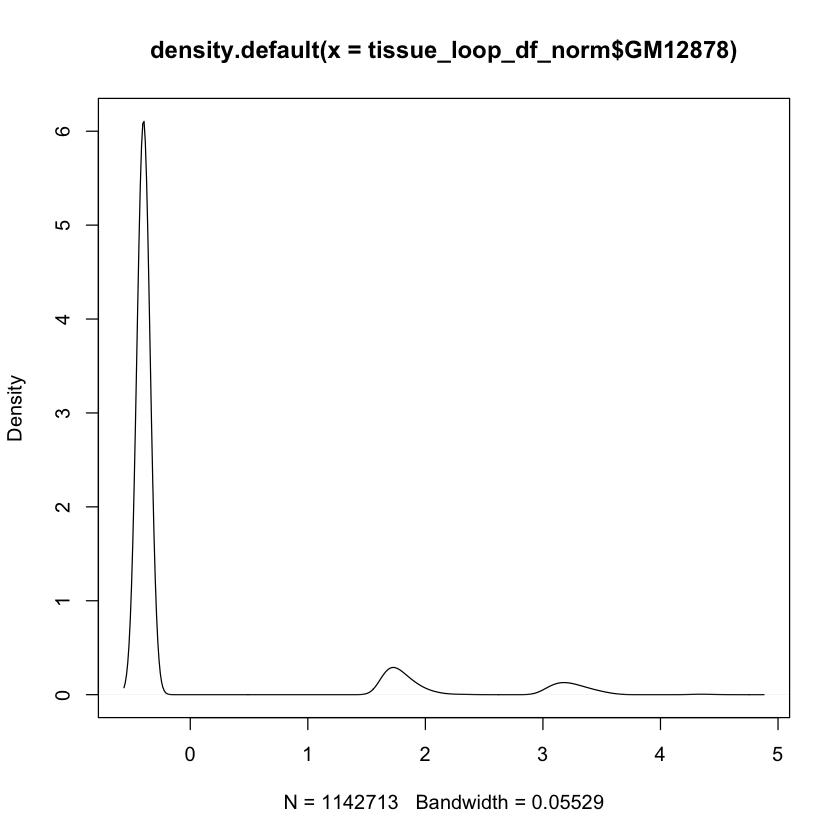

In [59]:
par (bg='white')
plot(density(tissue_loop_df_norm$"GM12878"))

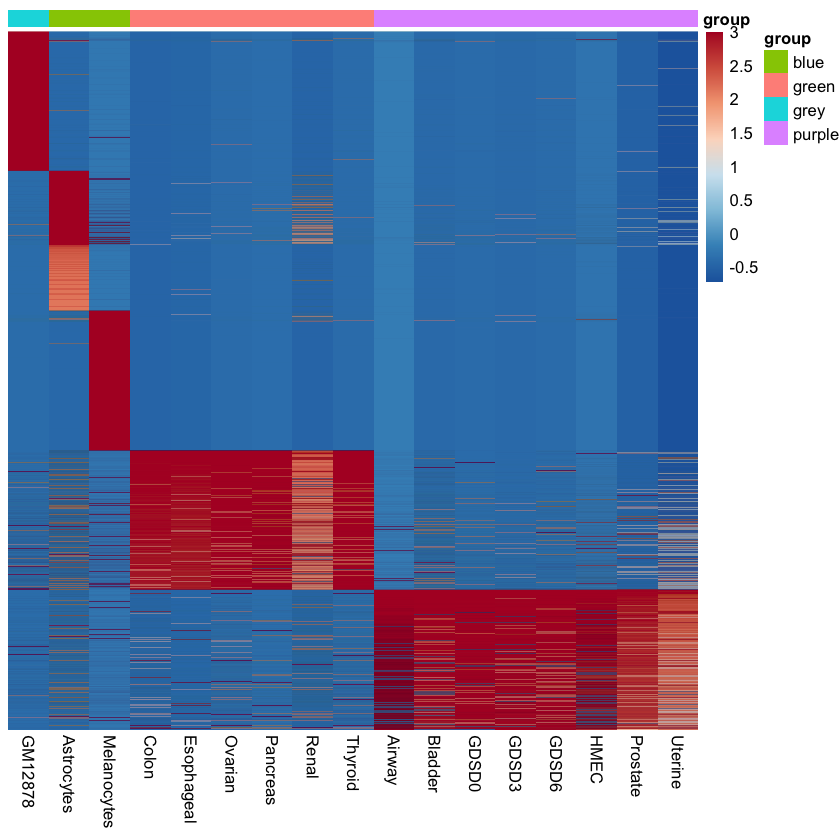

In [60]:
p_10000 = pheatmap(tissue_loop_sig,
             cluster_rows=F,
             cluster_cols=F,
                show_rownames=F,
             annotation_col=annon_df,
               color = colorRampPalette(rev(brewer.pal(n =8, name ="RdBu")))(255))


In [133]:
save_pheatmap_png( p_10000, paste0(save_prefix, 'heatmap_top10000.png'), height=2000,width=2000,res=300)

pdf 
  2

# getting gene signatures

In [6]:
purple_loops= sig_loop_list$purple[ sig_loop_list$purple %in% select_loops]
length(purple_loops)
green_loops = sig_loop_list$green[ sig_loop_list$green %in% select_loops]
length(green_loops)
blue1_loops  = sig_loop_list$blue1[ sig_loop_list$blue1 %in% select_loops]
length(blue1_loops)
blue2_loops  = sig_loop_list$blue2[ sig_loop_list$blue1 %in% select_loops]
length(blue2_loops)
grey_loops  = sig_loop_list$grey[ sig_loop_list$grey %in% select_loops]
length(grey_loops)
all_loops = rownames(tissue_loop_df_norm)
length(all_loops)

ERROR: Error in eval(expr, envir, enclos): object 'sig_loop_list' not found


In [7]:
get_genes = function(loops){
    df = data.frame("loop"=loops)%>%
        separate(loop, c('source','target'), sep='::')
    df_anc <- data.frame("anchor" = unique(c(df[,"source"], df[,"target"]))) %>%
        separate(anchor, c("chr", "start", "stop"), sep='_')
    df_gr = makeGRangesFromDataFrame(df_anc)#                         seqnames.field=c("seqnames", "seqname",
    df_gr_anno = annotatePeak(df_gr, TxDb = TxDb.Hsapiens.UCSC.hg19.knownGene)

    df_gr_anno <- as.data.frame(df_gr_anno)
    df_gr_anno$symbol <- mapIds(org.Hs.eg.db, keys=df_gr_anno$geneId, column="SYMBOL", keytype="ENTREZID", multiVals="first")

    genes = unique(df_gr_anno$symbol)
    return(genes)
}

In [63]:
purple_genes= get_genes(purple_loops)
length(purple_genes)
green_genes = get_genes(green_loops)
length(green_genes)
blue1_genes  = get_genes(blue1_loops)
length(blue1_genes)
blue2_genes  = get_genes(blue2_loops)
length(blue2_genes)
grey_genes  = get_genes(grey_loops)
length(grey_genes)

>> preparing features information...		 2020-05-11 16:12:16 
>> identifying nearest features...		 2020-05-11 16:12:16 
>> calculating distance from peak to TSS...	 2020-05-11 16:12:17 
>> assigning genomic annotation...		 2020-05-11 16:12:17 
>> assigning chromosome lengths			 2020-05-11 16:12:30 
>> done...					 2020-05-11 16:12:30 


'select()' returned 1:1 mapping between keys and columns



[1] 2676

>> preparing features information...		 2020-05-11 16:12:30 
>> identifying nearest features...		 2020-05-11 16:12:30 
>> calculating distance from peak to TSS...	 2020-05-11 16:12:31 
>> assigning genomic annotation...		 2020-05-11 16:12:31 
>> assigning chromosome lengths			 2020-05-11 16:12:32 
>> done...					 2020-05-11 16:12:32 


'select()' returned 1:1 mapping between keys and columns



[1] 3764

>> preparing features information...		 2020-05-11 16:12:32 
>> identifying nearest features...		 2020-05-11 16:12:32 
>> calculating distance from peak to TSS...	 2020-05-11 16:12:33 
>> assigning genomic annotation...		 2020-05-11 16:12:33 
>> assigning chromosome lengths			 2020-05-11 16:12:34 
>> done...					 2020-05-11 16:12:34 


'select()' returned 1:1 mapping between keys and columns



[1] 3318

>> preparing features information...		 2020-05-11 16:12:35 
>> identifying nearest features...		 2020-05-11 16:12:35 
>> calculating distance from peak to TSS...	 2020-05-11 16:12:35 
>> assigning genomic annotation...		 2020-05-11 16:12:35 
>> assigning chromosome lengths			 2020-05-11 16:12:37 
>> done...					 2020-05-11 16:12:37 


'select()' returned 1:1 mapping between keys and columns



[1] 4924

>> preparing features information...		 2020-05-11 16:12:37 
>> identifying nearest features...		 2020-05-11 16:12:37 
>> calculating distance from peak to TSS...	 2020-05-11 16:12:37 
>> assigning genomic annotation...		 2020-05-11 16:12:37 
>> assigning chromosome lengths			 2020-05-11 16:12:39 
>> done...					 2020-05-11 16:12:39 


'select()' returned 1:1 mapping between keys and columns



[1] 2688

In [64]:
write.table(sort(purple_genes), file = paste0(save_prefix, "purple_genes.csv"),row.names=FALSE,col.names=FALSE)
write.table(sort(green_genes), file = paste0(save_prefix, "green_genes.csv"),row.names=FALSE,col.names=FALSE)
write.table(sort(blue1_genes), file = paste0(save_prefix, "blue1_genes.csv"),row.names=FALSE,col.names=FALSE)
write.table(sort(blue2_genes), file = paste0(save_prefix, "blue2_genes.csv"),row.names=FALSE,col.names=FALSE)
write.table(sort(grey_genes), file = paste0(save_prefix, "grey_genes.csv"),row.names=FALSE,col.names=FALSE)
# write.table(sort(all_genes), file = paste0(save_prefix, "all_genes.csv"),row.names=FALSE,col.names=FALSE)


In [88]:
library(VennDiagram)
 
# Chart
venn.diagram(
    x = list("purple"=purple_genes, "green"=green_genes, "blue1"=blue1_genes,"blue2"=blue2_genes, "grey"=grey_genes),
  filename = paste0(save_prefix,'venn_diagram.png'),
#   output=TRUE
 # Output features
    imagetype="png" ,
#     height = 40 , 
#     width = 40 , 
#     resolution = 200,
#     compression = "lzw",

#     # Circles
#     lwd = 2,
#     lty = 'blank',
    fill = c("purple","green", "lightblue","blue", "grey"),
        
)


[1] 1

In [31]:
'CD22' %in% grey_only

[1] FALSE

In [30]:
grey_only

[1] A4GALT         AAAS           AATBC          ABCB9         
   [5] ABCC4          ABHD12B        ABR            ACADM         
   [9] ACAP1          ACO2           ACP5           ACSL1         
  [13] ACVR2A         ADA2           ADAM19         ADAM22        
  [17] ADAP2          ADAT1          ADD3           ADD3-AS1      
  [21] ADGRG5         ADO            ADORA2A        ADORA3        
  [25] ADPRH          AEN            AFAP1-AS1      AFF3          
  [29] AFG1L          AGBL3          AGO3           AGPAT3        
  [33] AGPAT5         AHNAK          AICDA          AIM2          
  [37] AIP            AKAP11         AKAP5          AKR1D1        
  [41] AKT1S1         ALDH16A1       ALDH5A1        ALDOC         
  [45] ALG2           ALOX5          ALPK1          AMMECR1L      
  [49] AMN1           AMZ2P1         ANGPTL6        ANK1          
  [53] ANKDD1A        ANKLE2         ANKRD22        ANKRD28       
  [57] ANKRD36BP2     ANKRD44        AP1G1          AP4B1-AS1     
  [61] APBB1          APBB1IP        APBB3          APOA2         
  [65] APOBEC3C       APOBEC3D       APOBEC3F       APOBEC3G      
  [69] APOBEC3H       APOL1          APOL3          ARAP1         
  [73] ARFGAP3        ARHGAP15       ARHGAP17       ARHGAP22      
  [77] ARHGAP30       ARHGAP9        ARHGEF17       ARHGEF3       
  [81] ARHGEF3-AS1    ARID1A         ARID1B         ARID5A        
  [85] ARMC9          ARMH3          ARPC3          ARPP19        
  [89] ARSB           ARSG           ASAP3          ASB2          
  [93] ASB9P1         ASTL           ASXL1          ATAD2B        
  [97] ATF4           ATF7           ATF7IP2        ATP2A3        
 [101] ATP2B1-AS1     ATP6V0A2       ATP6V1G3       ATP8A1        
 [105] ATXN1L         AURKB          B2M            B4GALNT4      
 [109] BANF2          BCAS4          BCL11A         BCL2A1        
 [113] BCL2L15        BFSP2          BHLHA9         BID           
 [117] BLM            BLNK           BMPR1A         BNIP5         
 [121] BORCS6         BORCS8-MEF2B   BTBD19         BTG1          
 [125] BTLA           BUB1B          BUB3           C10orf142     
 [129] C12orf49       C12orf76       C16orf54       C16orf78      
 [133] C16orf87       C19orf12       C19orf84       C1D           
 [137] C1GALT1C1      C1orf109       C1orf112       C1orf94       
 [141] C1QTNF6        C20orf144      C20orf204      C22orf46      
 [145] C2orf42        C2orf76        C3orf18        C3orf20       
 [149] C4orf19        C7orf33        CA13           CA5A          
 [153] CA8            CABP1          CABP4          CACNB4        
 [157] CAMK2D         CAMK4          CAND1          CAPSL         
 [161] CARM1          CARNS1         CASC15         CASS4         
 [165] CATSPER2P1     CBFA2T2        CBFB           CBL           
 [169] CBX3P2         CBY2           CCDC107        CCDC110       
 [173] CCDC113        CCDC126        CCDC146        CCDC155       
 [177] CCDC157        CCDC167        CCDC180        CCDC186       
 [181] CCDC197        CCDC50         CCDC6          CCDC63        
 [185] CCDC69         CCDC74A        CCL17          CCL18         
 [189] CCL22          CCL3           CCL4           CCL5          
 [193] CCM2           CCNC           CCNE1          CCR1          
 [197] CCR2           CCR6           CCR7           CCR8          
 [201] CCR9           CD1A           CD1B           CD1C          
 [205] CD1D           CD200R1        CD209          CD226         
 [209] CD27-AS1       CD300LF        CD320          CD37          
 [213] CD40           CD47           CD48           CD5           
 [217] CD52           CD53           CD5L           CD70          
 [221] CD72           CD79A          CD79B          CD80          
 [225] CD84           CD86           CDC42          CDC42EP3      
 [229] CDC73          CDCA7L         CDK14          CDKN1A        
 [233] CDYL2          CEACAM1        CEACAM18       CEACAM21      
 [237] CECR3          CELF2          CENPC        

## gene signature checking

In [16]:
purple_genes = read.table(file = paste0(save_prefix, "purple_genes.csv"))$V1
green_genes = read.table(file = paste0(save_prefix, "green_genes.csv"))$V1
blue1_genes = read.table(file = paste0(save_prefix, "blue1_genes.csv"))$V1
blue2_genes = read.table(file = paste0(save_prefix, "blue2_genes.csv"))$V1
grey_genes = read.table(file = paste0(save_prefix, "grey_genes.csv"))$V1


library(VennDiagram)  
overlap = calculate.overlap(
  x = list("purple"=purple_genes, "green"=green_genes, "blue1"=blue1_genes,"blue2"=blue2_genes, "grey"=grey_genes))
purple_only = overlap[[31]]
blue1_only = overlap[[29]]
blue2_only = overlap[[28]]
green_only = overlap[[30]]
grey_only = overlap[[27]]

Loading required package: grid

Loading required package: futile.logger



In [17]:
for (x in overlap){
    print(length(x))
}

[1] 57
[1] 130
[1] 19
[1] 22
[1] 66
[1] 85
[1] 94
[1] 253
[1] 184
[1] 98
[1] 67
[1] 37
[1] 93
[1] 90
[1] 46
[1] 115
[1] 372
[1] 449
[1] 605
[1] 225
[1] 268
[1] 245
[1] 176
[1] 308
[1] 131
[1] 155
[1] 1086
[1] 2000
[1] 944
[1] 1670
[1] 993


In [18]:
write.table(sort(purple_only), file = paste0(save_prefix, "purple_only.csv"),row.names=FALSE,col.names=FALSE)
write.table(sort(blue1_only), file = paste0(save_prefix, "blue1_only.csv"),row.names=FALSE,col.names=FALSE)
write.table(sort(blue2_only), file = paste0(save_prefix, "blue2_only.csv"),row.names=FALSE,col.names=FALSE)
write.table(sort(green_only), file = paste0(save_prefix, "green_only.csv"),row.names=FALSE,col.names=FALSE)
write.table(sort(grey_only), file = paste0(save_prefix, "grey_only.csv"),row.names=FALSE,col.names=FALSE)


In [19]:
# # length(purple_genes[!(purple_genes %in% c(green_genes, blue_genes, grey_genes))])
# length(blue1_genes[!(blue1_genes %in% c(purple_genes, green_genes, blue2_genes,grey_genes))])

In [20]:
purple_entrez = bitr(purple_genes, fromType="SYMBOL", toType="ENTREZID", OrgDb="org.Hs.eg.db")$ENTREZID
green_entrez = bitr(green_genes, fromType="SYMBOL", toType="ENTREZID", OrgDb="org.Hs.eg.db")$ENTREZID
blue1_entrez = bitr(blue1_genes, fromType="SYMBOL", toType="ENTREZID", OrgDb="org.Hs.eg.db")$ENTREZID
blue2_entrez = bitr(blue2_genes, fromType="SYMBOL", toType="ENTREZID", OrgDb="org.Hs.eg.db")$ENTREZID
grey_entrez = bitr(grey_genes, fromType="SYMBOL", toType="ENTREZID", OrgDb="org.Hs.eg.db")$ENTREZID

# all_entrez = bitr(all_genes, fromType="SYMBOL", toType="ENTREZID", OrgDb="org.Hs.eg.db")$ENTREZID


'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:many mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:many mapping between keys and columns



In [21]:
length(purple_entrez)
length(green_entrez)
length(blue1_entrez)
length(blue2_entrez)
length(grey_entrez)
# length(all_entrez)

[1] 2675

[1] 3764

[1] 3317

[1] 4923

[1] 2688

In [22]:
cluster_all <- list(purple = purple_entrez, 
                       green = green_entrez,
                      blue1 = blue1_entrez,
                      blue2 = blue2_entrez,
                      grey = grey_entrez)

In [22]:
ck_reactome_90 <- compareCluster(geneCluster = cluster_all, 
                                 fun = "enrichPathway", pAdjustMethod='none', pvalueCutoff = 1,readable=TRUE)
write.csv(ck_reactome_90, file = paste0(save_prefix, "ck_reactome_groups.csv"))

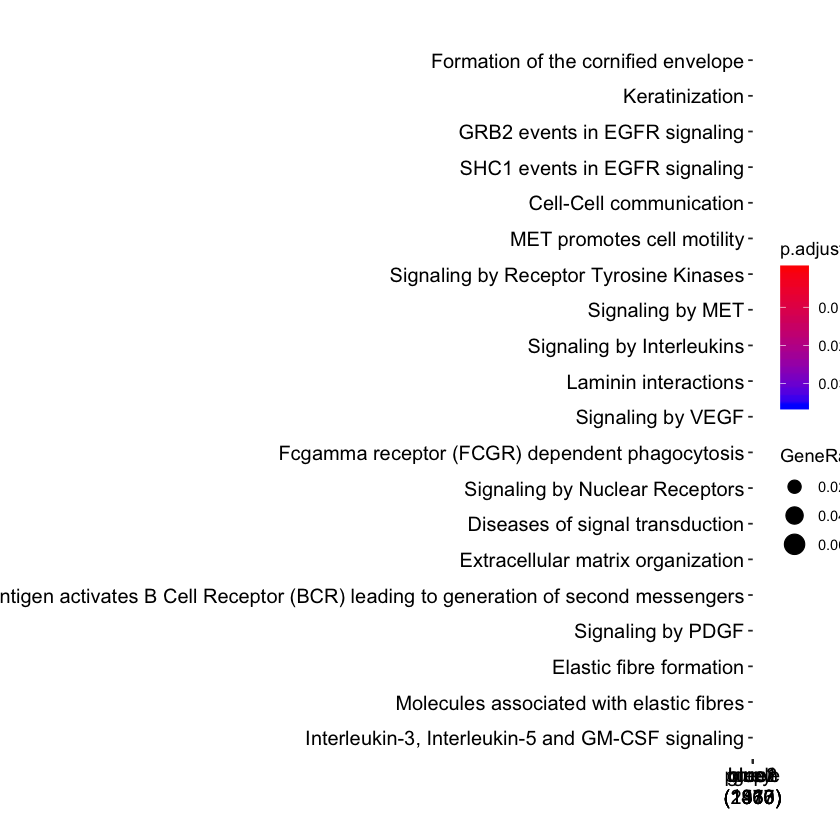

In [23]:
dotplot(ck_reactome_90)
ggsave(file = paste0(save_prefix, "ck_reactome_groups.pdf"),height=7, width=10)

In [24]:
ck_go_bp <- compareCluster(geneCluster = cluster_all, fun = "enrichGO", 
                                pAdjustMethod='BH', 
                                pvalueCutoff  = 0.05,
                                qvalueCutoff  = 0.05,
                                OrgDb='org.Hs.eg.db', 
                                ont = "BP",
                                readable=TRUE)
head(as.data.frame(ck_go_bp))
write.csv(ck_go_bp, file=paste0(save_prefix, 'ck_go_bp_05.csv'))

ck_go_mf <- compareCluster(geneCluster = cluster_all, fun = "enrichGO", 
                                pAdjustMethod='BH', 
                                pvalueCutoff  = 0.05,
                                qvalueCutoff  = 0.05,
                                OrgDb='org.Hs.eg.db', 
                                ont = "MF",
                                readable=TRUE)                              
head(as.data.frame(ck_go_mf))
write.csv(ck_go_mf, file=paste0(save_prefix, 'ck_go_mf_05.csv'))


ck_go_cc <- compareCluster(geneCluster = cluster_all, fun = "enrichGO", 
                                pAdjustMethod='BH', 
                                pvalueCutoff  = 0.05,
                                qvalueCutoff  = 0.05,
                                OrgDb='org.Hs.eg.db', 
                                ont = "CC",
                                readable=TRUE)
head(as.data.frame(ck_go_cc))
write.csv(ck_go_cc, file=paste0(save_prefix, 'ck_go_cc_05.csv'))

,Cluster,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<fct>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
1,purple,GO:0008544,epidermis development,129/2126,464/18670,7.904353e-23,4.875405e-19,3.904751e-19,ABCA12/ANXA1/APCDD1/ATP2A2/BCL2/BNC1/CALML5/CD109/CDH3/CELSR1/COL17A1/COL7A1/CSTA/CTSV/DKK1/DSC1/DSC2/DSC3/DSG1/DSG2/DSG3/DSP/EGFR/EREG/ERRFI1/EXPH5/FABP5/FGFR2/FLG2/FOSL2/FOXQ1/FST/GRHL1/GRHL2/GRHL3/HRNR/INHBA/IRF6/IVL/JAG1/JUP/KAZN/KEAP1/KLF4/KLF7/KLK5/KRT1/KRT13/KRT14/KRT15/KRT16/KRT17/KRT20/KRT23/KRT28/KRT31/KRT33A/KRT33B/KRT34/KRT36/KRT37/KRT39/KRT5/KRT6A/KRT6B/KRT6C/KRT74/KRT75/KRT78/KRT8/KRT80/KRT81/KRT82/KRT83/KRT84/KRT85/KRT86/KRT9/KRTAP1-1/KRTAP16-1/KRTAP17-1/KRTAP2-3/KRTAP2-4/KRTAP29-1/KRTAP3-2/KRTAP4-11/KRTAP4-6/KRTAP4-8/KRTAP9-7/LAMB3/LAMC2/LCE5A/LELP1/LGR4/LRTOMT/MYO5A/NAB2/NOTCH1/NUMA1/PAFAH1B1/PALLD/PERP/PKP1/POU2F3/PPARD/PRKCH/PTHLH/RBP2/RPTN/RUNX1/SATB1/SERPINB13/SFN/SLC4A7/SOS1/SOX9/SPINK5/SPINK6/SPINK9/SPRR2D/SPRR2F/SPRR2G/TCHH/TP63/TRIOBP/UGCG/YAP1/ZFP36L1/ZNF750,129
2,purple,GO:0070268,cornification,54/2126,112/18670,2.694018e-22,8.308352e-19,6.654225e-19,CSTA/DSC1/DSC2/DSC3/DSG1/DSG2/DSG3/DSP/IVL/JUP/KAZN/KLK5/KRT1/KRT13/KRT14/KRT15/KRT16/KRT17/KRT20/KRT23/KRT28/KRT31/KRT33A/KRT33B/KRT34/KRT36/KRT37/KRT39/KRT5/KRT6A/KRT6B/KRT6C/KRT74/KRT75/KRT78/KRT8/KRT80/KRT81/KRT82/KRT83/KRT84/KRT85/KRT86/KRT9/PERP/PKP1/RPTN/SPINK5/SPINK6/SPINK9/SPRR2D/SPRR2F/SPRR2G/TCHH,54
3,purple,GO:0030216,keratinocyte differentiation,92/2126,305/18670,3.698981e-19,7.605106e-16,6.090989e-16,ABCA12/ANXA1/CD109/CDH3/CSTA/CTSV/DSC1/DSC2/DSC3/DSG1/DSG2/DSG3/DSP/EREG/ERRFI1/EXPH5/FOSL2/GRHL1/GRHL2/HRNR/IRF6/IVL/JAG1/JUP/KAZN/KLK5/KRT1/KRT13/KRT14/KRT15/KRT16/KRT17/KRT20/KRT23/KRT28/KRT31/KRT33A/KRT33B/KRT34/KRT36/KRT37/KRT39/KRT5/KRT6A/KRT6B/KRT6C/KRT74/KRT75/KRT78/KRT8/KRT80/KRT81/KRT82/KRT83/KRT84/KRT85/KRT86/KRT9/KRTAP1-1/KRTAP16-1/KRTAP17-1/KRTAP2-3/KRTAP2-4/KRTAP29-1/KRTAP3-2/KRTAP4-11/KRTAP4-6/KRTAP4-8/KRTAP9-7/LCE5A/LELP1/NOTCH1/NUMA1/PALLD/PERP/PKP1/PRKCH/RPTN/RUNX1/SERPINB13/SFN/SPINK5/SPINK6/SPINK9/SPRR2D/SPRR2F/SPRR2G/TCHH/TP63/UGCG/YAP1/ZFP36L1,92
4,purple,GO:0043588,skin development,113/2126,419/18670,5.112409e-19,7.883335e-16,6.313826e-16,ABCA12/ANXA1/APCDD1/BCL2/CD109/CDH3/CELSR1/CLDN1/COL5A2/CSTA/CTSV/DKK1/DSC1/DSC2/DSC3/DSG1/DSG2/DSG3/DSP/EGFR/EREG/ERRFI1/EXPH5/FGFR2/FLG2/FOSL2/FOXQ1/FST/GRHL1/GRHL2/GRHL3/HRNR/INHBA/IRF6/ITGA2/ITGA6/IVL/JAG1/JUP/KAZN/KLK5/KRT1/KRT13/KRT14/KRT15/KRT16/KRT17/KRT20/KRT23/KRT28/KRT31/KRT33A/KRT33B/KRT34/KRT36/KRT37/KRT39/KRT5/KRT6A/KRT6B/KRT6C/KRT74/KRT75/KRT78/KRT8/KRT80/KRT81/KRT82/KRT83/KRT84/KRT85/KRT86/KRT9/KRTAP1-1/KRTAP16-1/KRTAP17-1/KRTAP2-3/KRTAP2-4/KRTAP29-1/KRTAP3-2/KRTAP4-11/KRTAP4-6/KRTAP4-8/KRTAP9-7/LCE5A/LELP1/LGR4/MET/MYO5A/NOTCH1/NUMA1/PALLD/PERP/PKP1/PRKCH/RPTN/RUNX1/SERPINB13/SFN/SOS1/SOX9/SPINK5/SPINK6/SPINK9/SPRR2D/SPRR2F/SPRR2G/STMN1/TCHH/TP63/UGCG/YAP1/ZFP36L1,113
5,purple,GO:0009913,epidermal cell differentiation,99/2126,358/18670,1.297138e-17,1.600149e-14,1.281572e-14,ABCA12/ANXA1/CD109/CDH3/CSTA/CTSV/DSC1/DSC2/DSC3/DSG1/DSG2/DSG3/DSP/EREG/ERRFI1/EXPH5/FOSL2/GRHL1/GRHL2/HRNR/IRF6/IVL/JAG1/JUP/KAZN/KEAP1/KLF4/KLF7/KLK5/KRT1/KRT13/KRT14/KRT15/KRT16/KRT17/KRT20/KRT23/KRT28/KRT31/KRT33A/KRT33B/KRT34/KRT36/KRT37/KRT39/KRT5/KRT6A/KRT6B/KRT6C/KRT74/KRT75/KRT78/KRT8/KRT80/KRT81/KRT82/KRT83/KRT84/KRT85/KRT86/KRT9/KRTAP1-1/KRTAP16-1/KRTAP17-1/KRTAP2-3/KRTAP2-4/KRTAP29-1/KRTAP3-2/KRTAP4-11/KRTAP4-6/KRTAP4-8/KRTAP9-7/LCE5A/LELP1/LRTOMT/NOTCH1/NUMA1/PAFAH1B1/PALLD/PERP/PKP1/PRKCH/RPTN/RUNX1/SERPINB13/SFN/SLC4A7/SPINK5/SPINK6/SPINK9/SPRR2D/SPRR2F/SPRR2G/TCHH/TP63/TRIOBP/UGCG/YAP1/ZFP36L1,99
6,purple,GO:0034330,cell junction organization,83/2126,290/18670,6.407880e-16,6.587300e-13,5.275821e-13,ACTN4/ANK2/ARF6/ARHGEF7/ARVCF/BCL2/BMP6/CAV1/CD9/CDH1/CDH17/CDH20/CDH26/CDH3/CLASP1/CLDN1/COL17A1/CORO1C/CORO2B/CTNND1/DLC1/DLG5/DSG1/DSG2/DSP/DST/EFNA5/F11R/F2R/F2RL1/FBLIM1/FSCN1/GJA1/GJB2/GRHL1/GRHL2/ITGA2/ITGA5/ITGA6/JUP/KIFC3/KRT14/KRT5/LAMB3/LAMC1/LA

,Cluster,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<fct>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
1,purple,GO:0050839,cell adhesion molecule binding,103/2077,499/17697,5.465178e-09,6.022626e-06,5.511200e-06,ABI1/ACTN4/ACVR1/ADAMTS8/ANXA1/ANXA2/ARHGAP18/ARVCF/ATIC/BAG3/BAIAP2/CALD1/CCN4/CCN6/CD9/CDC42EP1/CDH1/CDH17/CDH20/CDH26/CDH3/CDK5R1/CLINT1/COBLL1/CRKL/CTNND1/DNAJB1/DOCK9/DSG2/DSP/DST/EGFR/EPN2/ERC1/ESM1/F11R/FSCN1/FXYD5/GIPC1/GLOD4/HDLBP/HMCN1/HSPA8/IL1B/ITGA2/ITGA5/ITGA6/ITGB1/ITGB6/JAML/JUP/KIF5B/LAD1/LYN/MACF1/MAPRE1/MARK2/MICALL1/MPP7/MYO1B/NDRG1/NECTIN1/NECTIN4/NOTCH3/NPTN/NRG1/PARK7/PDLIM1/PHLDB2/PICALM/PKM/PKP1/PPFIBP1/PSMB6/PTPN1/PTPRD/PTPRO/PTPRZ1/RPL14/RPL29/S100A11/SEMA7A/SEPTIN2/SERBP1/SFN/SLC14A2/SLK/SNX2/SNX9/SPTBN1/SRC/STK24/SYK/TENM2/TENM4/TES/THBS1/TJP2/TMOD3/TNKS1BP1/TRIM29/UBAP2/YWHAZ,103
2,purple,GO:0045296,cadherin binding,75/2077,331/17697,1.184463e-08,6.526392e-06,5.972187e-06,ABI1/ACVR1/ANXA1/ANXA2/ARHGAP18/ARVCF/ATIC/BAG3/BAIAP2/CALD1/CDC42EP1/CDH1/CDH17/CDH20/CDH26/CDH3/CDK5R1/CLINT1/COBLL1/CRKL/CTNND1/DNAJB1/DOCK9/EGFR/EPN2/ERC1/F11R/FSCN1/FXYD5/GIPC1/GLOD4/HDLBP/HSPA8/ITGA6/ITGB1/JUP/KIF5B/LAD1/MACF1/MAPRE1/MARK2/MICALL1/MPP7/MYO1B/NDRG1/NOTCH3/PARK7/PDLIM1/PHLDB2/PICALM/PKM/PKP1/PPFIBP1/PSMB6/PTPN1/PTPRO/RPL14/RPL29/S100A11/SEPTIN2/SERBP1/SFN/SLK/SNX2/SNX9/SPTBN1/SRC/STK24/TES/TJP2/TMOD3/TNKS1BP1/TRIM29/UBAP2/YWHAZ,75
3,purple,GO:0003779,actin binding,86/2077,431/17697,4.638139e-07,1.703743e-04,1.559066e-04,ABLIM1/ACTN4/ACTR3/ARPC1A/CALD1/CAP1/CAPZA2/CDK5R1/COBLL1/CORO1C/CORO2B/CORO6/DAAM1/DIAPH1/DIXDC1/DST/EGFR/EVL/FBXO25/FGD4/FHOD1/FHOD3/FMNL3/FSCN1/FXYD5/GIPC1/GSN/IMPACT/INO80/IQGAP2/ITGB1/ITPRID2/JMY/KCNMA1/KLHL2/MACF1/MARCKS/MICAL2/MRTFA/MTSS1/MYO10/MYO16/MYO1B/MYO1E/MYO5A/MYO5B/MYOM3/MYOZ2/MYPN/MYRIP/NOD2/PALLD/PANX1/PAWR/PDLIM1/PHACTR1/POF1B/PTK2/SHROOM2/SHROOM3/SHROOM4/SLC6A2/SMTN/SORBS1/SPIRE1/SPTBN1/SSH1/SSH2/STK38L/SVIL/SYNE1/SYNE2/SYNPO2/TMOD3/TNNI1/TNNT2/TPM1/TRIOBP/TRPC6/TRPV4/VASH1/WASF1/WASL/WDR1/YWHAH/ZNF185,86
4,purple,GO:0005088,Ras guanyl-nucleotide exchange factor activity,34/2077,137/17697,1.533668e-05,4.225255e-03,3.866458e-03,ADRB1/AKAP13/ARHGEF10/ARHGEF10L/ARHGEF28/ARHGEF37/ARHGEF4/ARHGEF7/C9orf72/DENND1B/DENND2C/DENND6A/DNMBP/ECT2L/FGD2/FGD4/FGD6/ITSN1/MCF2L2/NET1/PLEKHG3/PLEKHG4/PLEKHG5/PLEKHG6/RAB3GAP2/RAB3IP/RAPGEF1/RAPGEF3/RAPGEF4/RAPGEF5/RASGEF1B/RCBTB2/RIN2/SOS1,34
5,purple,GO:0045499,chemorepellent activity,12/2077,27/17697,2.105613e-05,4.359828e-03,3.989603e-03,EFNA5/FLRT2/FLRT3/NRG1/SEMA3A/SEMA3C/SEMA3F/SEMA4B/SEMA4F/SEMA5B/SEMA6D/SEMA7A,12
6,purple,GO:0098631,cell adhesion mediator activity,19/2077,59/17697,2.580841e-05,4.359828e-03,3.989603e-03,ANXA1/ANXA2/BAIAP2/CD200/CDC42EP1/DSC2/DSG2/DSP/ITGA2/ITGB1/JUP/MYPN/NPTN/PALLD/PDLIM1/S100A11/SIRPA/TMOD3/TRIM29,19


,Cluster,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<fct>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
1,purple,GO:0005911,cell-cell junction,116/2213,459/19717,1.348479e-17,9.371928e-15,8.261207e-15,ABCC2/ACTN4/ACTR3/ADGRL3/AKAP6/AKR1B1/AMOTL1/ANK2/ANXA1/ANXA2/ARVCF/ATP2A2/B4GALT1/BAIAP2/CD2/CD3E/CD99L2/CDC42EP1/CDC42EP4/CDH1/CDH17/CDH20/CDH26/CDH3/CLDN1/CLDN14/CLDN16/CLDN17/CLDN8/COL17A1/CTNND1/CYTH1/CYTH3/DLG5/DNMBP/DPP4/DSC1/DSC2/DSC3/DSG1/DSG2/DSG3/DSP/EPB41L4B/F11R/FABP7/FAT1/FAT2/FHOD1/FLRT2/FLRT3/FRMD4B/FRMD6/FSCN1/GJA1/GJA10/GJB2/GRHL2/HMCN1/ITGA5/ITGA6/ITGB1/JAML/JCAD/JUP/KAZN/KIFC3/KRT8/LAMA1/LSR/LYN/MAGI1/MPP7/MYO1E/NDRG1/NECTIN1/NECTIN4/NHS/PANX1/PARD3/PARD6G/PARK7/PCDHGA12/PDLIM1/PDZD2/PERP/PKD2/PKP1/PLEKHA7/PLEKHG5/POF1B/PTK7/PTPRK/RAP2B/S100A11/SCN1A/SH3KBP1/SHROOM2/SHROOM3/SHROOM4/SLC2A1/SLC5A1/SMAD7/SORBS1/SSX2IP/TBCD/TGFBR1/TJP2/TMEM65/TMOD3/TNKS1BP1/TRIM29/TRPC6/USP53/WDR1/YWHAH,116
2,purple,GO:0031252,cell leading edge,92/2213,403/19717,1.649371e-11,5.731564e-09,5.052284e-09,AAK1/ABI1/ABLIM1/ACTG2/ACTR3/AMOTL1/ANXA2/ARF6/ARHGEF4/ARHGEF7/ATP6V1B2/BAIAP2/BCAR1/BMX/C2CD5/CD44/CDH1/CLIP1/CORO1C/CSPG4/CTNND1/CYTH3/DIAPH1/DLC1/DPP4/DST/DUOX1/DUOX2/DYNLT1/DYSF/EVL/FAT1/FGD2/FGD4/FGD6/FRMD4B/FSCN1/GABARAPL1/GSN/IQGAP2/ITGA5/ITGB1/ITSN1/JCAD/JMY/KANK1/KITLG/KLHL2/LAYN/MACF1/MCC/MTSS1/MYO10/MYO5A/NEDD9/NHS/PAFAH1B1/PALLD/PHLDB2/PKD2/PLEKHA1/PLEKHG5/PSD3/PSD4/PTK2/PTPN13/PTPRK/PTPRO/RAB3IP/RAC1/RAPGEF3/ROBO2/S100A11/S100A6/SH3RF1/SLC1A2/SLC39A14/SLK/SNX2/SNX9/SPTBN1/SRC/SSH1/SSX2IP/SYNE2/THEM4/TPM1/TRPV1/TRPV4/VEZT/WASF1/WASL,92
3,purple,GO:0005913,cell-cell adherens junction,40/2213,117/19717,3.865182e-11,8.954338e-09,7.893108e-09,ANXA1/ANXA2/ARVCF/ATP2A2/BAIAP2/CD99L2/CDC42EP1/CDC42EP4/CDH1/CDH17/CDH20/CDH26/CDH3/CTNND1/DLG5/DSC2/DSP/FAT2/GJA1/HMCN1/ITGA6/JUP/KIFC3/LYN/NDRG1/NECTIN1/NECTIN4/PARD3/PARK7/PDLIM1/PKP1/PLEKHA7/S100A11/SHROOM2/SMAD7/SORBS1/SSX2IP/TMOD3/TNKS1BP1/TRIM29,40
4,purple,GO:0045111,intermediate filament cytoskeleton,65/2213,251/19717,6.141088e-11,1.067014e-08,9.405561e-09,CLIP1/CLK3/CSNK1A1/CTNS/DDX60/DSP/DST/GJA1/IFFO2/INO80/JUP/KRT1/KRT13/KRT14/KRT15/KRT16/KRT17/KRT20/KRT23/KRT28/KRT31/KRT33A/KRT33B/KRT34/KRT36/KRT37/KRT39/KRT5/KRT6A/KRT6B/KRT6C/KRT74/KRT75/KRT78/KRT8/KRT80/KRT81/KRT82/KRT83/KRT84/KRT85/KRT86/KRT9/KRTAP1-1/KRTAP16-1/KRTAP17-1/KRTAP2-3/KRTAP2-4/KRTAP29-1/KRTAP3-2/KRTAP4-11/KRTAP4-12/KRTAP4-6/KRTAP4-8/KRTAP9-7/MACF1/MYO5A/NOL9/NRP1/NSFL1C/PHLDB2/PKP1/SMARCA2/STN1/SYNE2,65
5,purple,GO:0005882,intermediate filament,55/2213,214/19717,2.407229e-09,3.346049e-07,2.949489e-07,CLIP1/CSNK1A1/DSP/DST/GJA1/IFFO2/JUP/KRT1/KRT13/KRT14/KRT15/KRT16/KRT17/KRT20/KRT23/KRT28/KRT31/KRT33A/KRT33B/KRT34/KRT36/KRT37/KRT39/KRT5/KRT6A/KRT6B/KRT6C/KRT74/KRT75/KRT78/KRT8/KRT80/KRT81/KRT82/KRT83/KRT84/KRT85/KRT86/KRT9/KRTAP1-1/KRTAP16-1/KRTAP17-1/KRTAP2-3/KRTAP2-4/KRTAP29-1/KRTAP3-2/KRTAP4-11/KRTAP4-12/KRTAP4-6/KRTAP4-8/KRTAP9-7/MACF1/MYO5A/NRP1/PKP1,55
6,purple,GO:0005925,focal adhesion,84/2213,405/19717,1.599897e-08,1.686252e-06,1.486405e-06,ACTN4/ACTR3/ALCAM/ANXA1/ARF6/ARHGEF7/BCAR1/CAP1/CAV1/CAV2/CD44/CD9/CD99L2/CDC42EP1/CLASP1/CORO1C/CORO2B/CSPG4/DIXDC1/DLC1/DPP4/DST/EFNB2/EGFR/EVL/FAT1/FBLIM1/FLRT2/FLRT3/GJA1/GSN/HSPA8/HSPB1/IGF2R/IRF2/ITGA2/ITGA5/ITGA6/ITGB1/ITGB6/JUP/KLF11/LAYN/LMO7/LPP/LRP1/MAP4K4/MAPRE1/MARCKS/MME/NEDD9/NHS/NOX4/NRP1/PALLD/PDLIM1/PHLDB2/PLAUR/PPFIBP1/PPP1CB/PTK2/PTK7/PTPN12/RAB21/RAC1/RND3/RPL10A/RPL37A/RRAS2/SH3KBP1/SORBS1/SVIL/SYNE2/SYNPO2/TES/TM4SF20/TNC/TNS3/TRIOBP/TRPV4/WASF1/YWHAG/YWHAZ/ZNF185,84


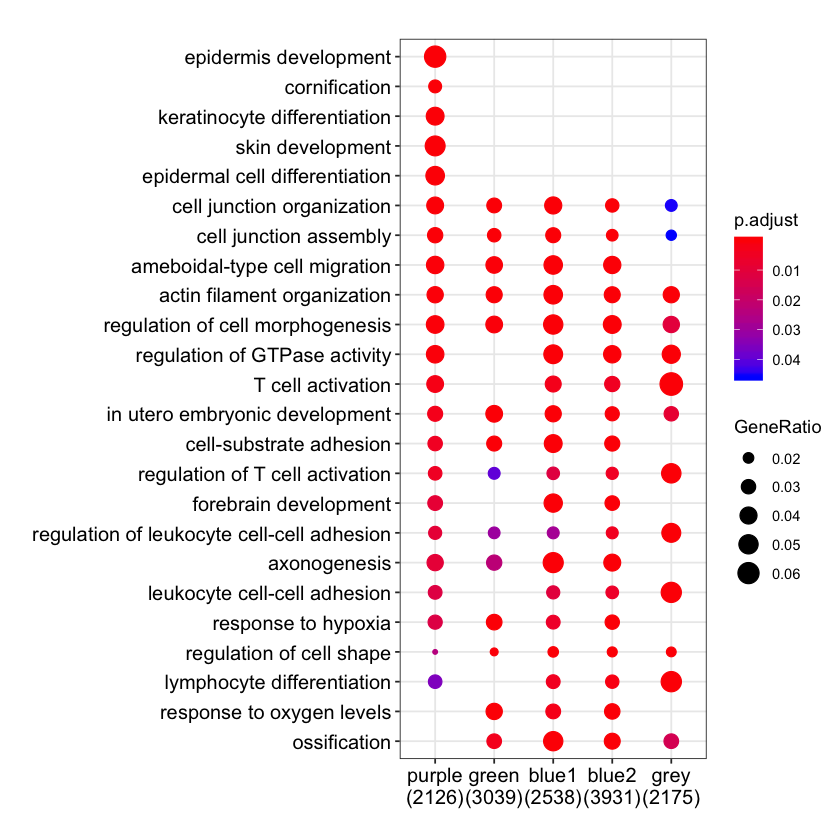

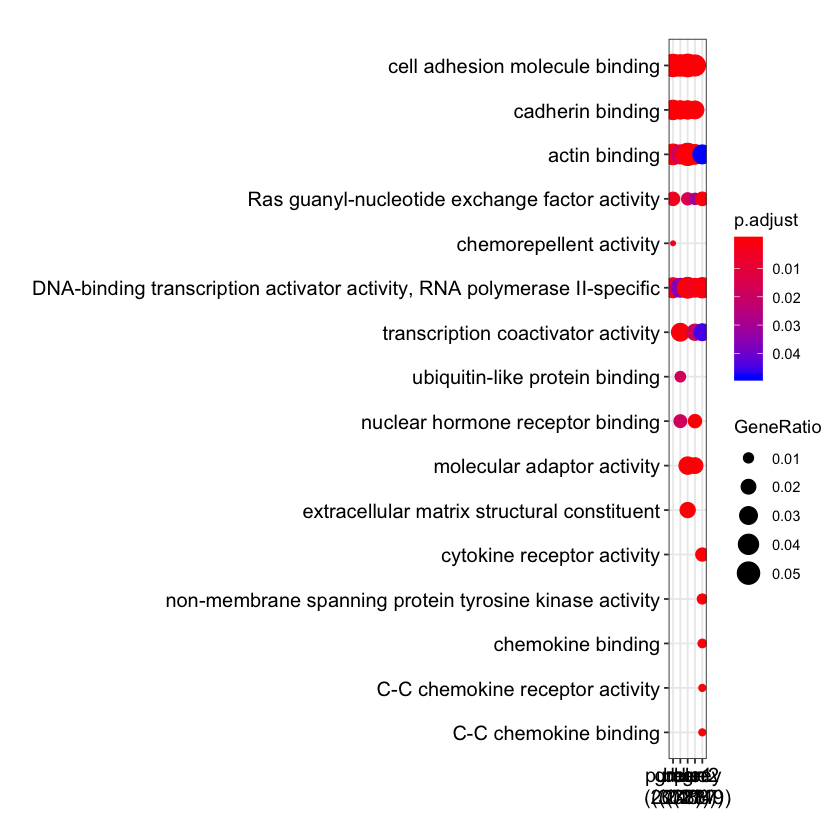

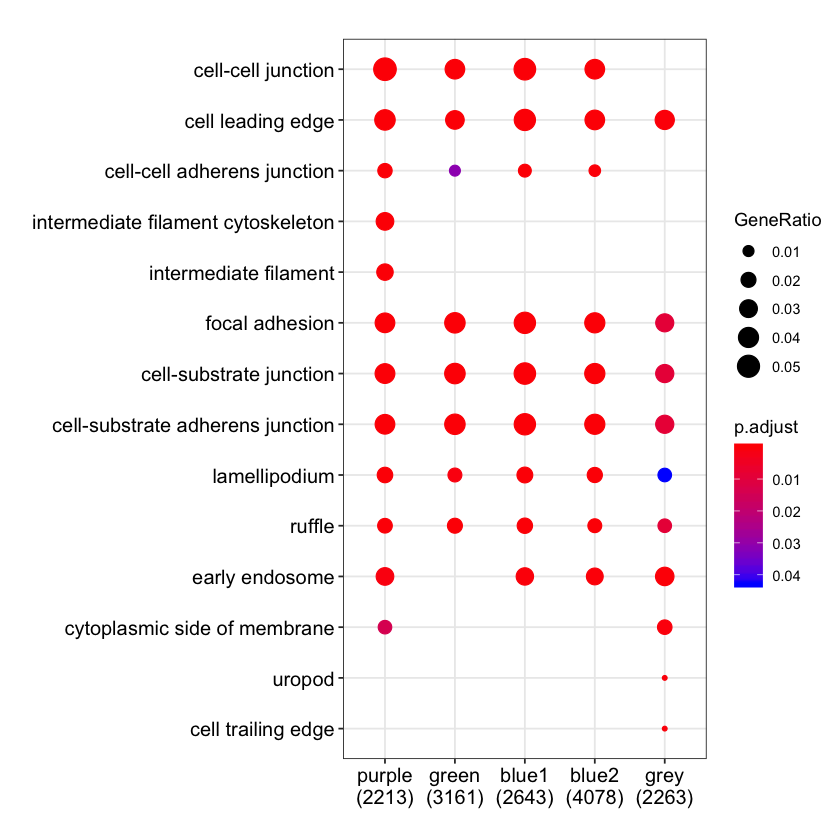

In [25]:
dotplot(ck_go_bp)
ggsave(file = paste0(save_prefix, "ck_go_bp_groups.pdf"),height=7, width=10)
dotplot(ck_go_mf)
ggsave(file = paste0(save_prefix, "ck_go_mf_groups.pdf"),height=7, width=10)
dotplot(ck_go_cc)
ggsave(file = paste0(save_prefix, "ck_go_cc_groups.pdf"),height=7, width=10)

manually edit `ck_go_bp_05.csv` and then reload

for selected go terms

In [23]:
ck_go_bp = read.csv(paste0(save_prefix,'ck_go_bp_05.csv'),row.names=1)
head(ck_go_bp)
dim(ck_go_bp)
ck_go_bp <- new("compareClusterResult",
               compareClusterResult = ck_go_bp,
               geneClusters = cluster_all,
               .call = match.call(expand.dots=TRUE)
               )
ck_go_bp@fun <- 'enrichGO'


,Cluster,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<fct>,<int>
1,purple,GO:0008544,epidermis development,129/2126,464/18670,7.904353e-23,4.875405e-19,3.904751e-19,ABCA12/ANXA1/APCDD1/ATP2A2/BCL2/BNC1/CALML5/CD109/CDH3/CELSR1/COL17A1/COL7A1/CSTA/CTSV/DKK1/DSC1/DSC2/DSC3/DSG1/DSG2/DSG3/DSP/EGFR/EREG/ERRFI1/EXPH5/FABP5/FGFR2/FLG2/FOSL2/FOXQ1/FST/GRHL1/GRHL2/GRHL3/HRNR/INHBA/IRF6/IVL/JAG1/JUP/KAZN/KEAP1/KLF4/KLF7/KLK5/KRT1/KRT13/KRT14/KRT15/KRT16/KRT17/KRT20/KRT23/KRT28/KRT31/KRT33A/KRT33B/KRT34/KRT36/KRT37/KRT39/KRT5/KRT6A/KRT6B/KRT6C/KRT74/KRT75/KRT78/KRT8/KRT80/KRT81/KRT82/KRT83/KRT84/KRT85/KRT86/KRT9/KRTAP1-1/KRTAP16-1/KRTAP17-1/KRTAP2-3/KRTAP2-4/KRTAP29-1/KRTAP3-2/KRTAP4-11/KRTAP4-6/KRTAP4-8/KRTAP9-7/LAMB3/LAMC2/LCE5A/LELP1/LGR4/LRTOMT/MYO5A/NAB2/NOTCH1/NUMA1/PAFAH1B1/PALLD/PERP/PKP1/POU2F3/PPARD/PRKCH/PTHLH/RBP2/RPTN/RUNX1/SATB1/SERPINB13/SFN/SLC4A7/SOS1/SOX9/SPINK5/SPINK6/SPINK9/SPRR2D/SPRR2F/SPRR2G/TCHH/TP63/TRIOBP/UGCG/YAP1/ZFP36L1/ZNF750,129
2,purple,GO:0070268,cornification,54/2126,112/18670,2.694018e-22,8.308352e-19,6.654225e-19,CSTA/DSC1/DSC2/DSC3/DSG1/DSG2/DSG3/DSP/IVL/JUP/KAZN/KLK5/KRT1/KRT13/KRT14/KRT15/KRT16/KRT17/KRT20/KRT23/KRT28/KRT31/KRT33A/KRT33B/KRT34/KRT36/KRT37/KRT39/KRT5/KRT6A/KRT6B/KRT6C/KRT74/KRT75/KRT78/KRT8/KRT80/KRT81/KRT82/KRT83/KRT84/KRT85/KRT86/KRT9/PERP/PKP1/RPTN/SPINK5/SPINK6/SPINK9/SPRR2D/SPRR2F/SPRR2G/TCHH,54
3,purple,GO:0030216,keratinocyte differentiation,92/2126,305/18670,3.698981e-19,7.605106e-16,6.090989e-16,ABCA12/ANXA1/CD109/CDH3/CSTA/CTSV/DSC1/DSC2/DSC3/DSG1/DSG2/DSG3/DSP/EREG/ERRFI1/EXPH5/FOSL2/GRHL1/GRHL2/HRNR/IRF6/IVL/JAG1/JUP/KAZN/KLK5/KRT1/KRT13/KRT14/KRT15/KRT16/KRT17/KRT20/KRT23/KRT28/KRT31/KRT33A/KRT33B/KRT34/KRT36/KRT37/KRT39/KRT5/KRT6A/KRT6B/KRT6C/KRT74/KRT75/KRT78/KRT8/KRT80/KRT81/KRT82/KRT83/KRT84/KRT85/KRT86/KRT9/KRTAP1-1/KRTAP16-1/KRTAP17-1/KRTAP2-3/KRTAP2-4/KRTAP29-1/KRTAP3-2/KRTAP4-11/KRTAP4-6/KRTAP4-8/KRTAP9-7/LCE5A/LELP1/NOTCH1/NUMA1/PALLD/PERP/PKP1/PRKCH/RPTN/RUNX1/SERPINB13/SFN/SPINK5/SPINK6/SPINK9/SPRR2D/SPRR2F/SPRR2G/TCHH/TP63/UGCG/YAP1/ZFP36L1,92
4,purple,GO:0043588,skin development,113/2126,419/18670,5.112409e-19,7.883335e-16,6.313826e-16,ABCA12/ANXA1/APCDD1/BCL2/CD109/CDH3/CELSR1/CLDN1/COL5A2/CSTA/CTSV/DKK1/DSC1/DSC2/DSC3/DSG1/DSG2/DSG3/DSP/EGFR/EREG/ERRFI1/EXPH5/FGFR2/FLG2/FOSL2/FOXQ1/FST/GRHL1/GRHL2/GRHL3/HRNR/INHBA/IRF6/ITGA2/ITGA6/IVL/JAG1/JUP/KAZN/KLK5/KRT1/KRT13/KRT14/KRT15/KRT16/KRT17/KRT20/KRT23/KRT28/KRT31/KRT33A/KRT33B/KRT34/KRT36/KRT37/KRT39/KRT5/KRT6A/KRT6B/KRT6C/KRT74/KRT75/KRT78/KRT8/KRT80/KRT81/KRT82/KRT83/KRT84/KRT85/KRT86/KRT9/KRTAP1-1/KRTAP16-1/KRTAP17-1/KRTAP2-3/KRTAP2-4/KRTAP29-1/KRTAP3-2/KRTAP4-11/KRTAP4-6/KRTAP4-8/KRTAP9-7/LCE5A/LELP1/LGR4/MET/MYO5A/NOTCH1/NUMA1/PALLD/PERP/PKP1/PRKCH/RPTN/RUNX1/SERPINB13/SFN/SOS1/SOX9/SPINK5/SPINK6/SPINK9/SPRR2D/SPRR2F/SPRR2G/STMN1/TCHH/TP63/UGCG/YAP1/ZFP36L1,113
5,purple,GO:0009913,epidermal cell differentiation,99/2126,358/18670,1.297138e-17,1.600149e-14,1.281572e-14,ABCA12/ANXA1/CD109/CDH3/CSTA/CTSV/DSC1/DSC2/DSC3/DSG1/DSG2/DSG3/DSP/EREG/ERRFI1/EXPH5/FOSL2/GRHL1/GRHL2/HRNR/IRF6/IVL/JAG1/JUP/KAZN/KEAP1/KLF4/KLF7/KLK5/KRT1/KRT13/KRT14/KRT15/KRT16/KRT17/KRT20/KRT23/KRT28/KRT31/KRT33A/KRT33B/KRT34/KRT36/KRT37/KRT39/KRT5/KRT6A/KRT6B/KRT6C/KRT74/KRT75/KRT78/KRT8/KRT80/KRT81/KRT82/KRT83/KRT84/KRT85/KRT86/KRT9/KRTAP1-1/KRTAP16-1/KRTAP17-1/KRTAP2-3/KRTAP2-4/KRTAP29-1/KRTAP3-2/KRTAP4-11/KRTAP4-6/KRTAP4-8/KRTAP9-7/LCE5A/LELP1/LRTOMT/NOTCH1/NUMA1/PAFAH1B1/PALLD/PERP/PKP1/PRKCH/RPTN/RUNX1/SERPINB13/SFN/SLC4A7/SPINK5/SPINK6/SPINK9/SPRR2D/SPRR2F/SPRR2G/TCHH/TP63/TRIOBP/UGCG/YAP1/ZFP36L1,99
6,purple,GO:0034330,cell junction organization,83/2126,290/18670,6.407880e-16,6.587300e-13,5.275821e-13,ACTN4/ANK2/ARF6/ARHGEF7/ARVCF/BCL2/BMP6/CAV1/CD9/CDH1/CDH17/CDH20/CDH26/CDH3/CLASP1/CLDN1/COL17A1/CORO1C/CORO2B/CTNND1/DLC1/DLG5/DSG1/DSG2/DSP/DST/EFNA5/F11R/F2R/F2RL1/FBLIM1/FSCN1/GJA1/GJB2/GRHL1/GRHL2/ITGA2/ITGA5/ITGA6/JUP/KIFC3/KRT14/KRT5/LAMB3/LAMC1/LA

[1] 4326   10

In [24]:
data.frame(ck_go_bp)%>%
    group_by(Description)%>%
    summarise(count=n())%>%
    dim()

[1] 2373    2

In [56]:
head(ck_go_bp)

,Cluster,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<fct>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
1,purple,GO:0008544,epidermis development,129/2126,464/18670,7.904353e-23,4.875405e-19,3.904751e-19,ABCA12/ANXA1/APCDD1/ATP2A2/BCL2/BNC1/CALML5/CD109/CDH3/CELSR1/COL17A1/COL7A1/CSTA/CTSV/DKK1/DSC1/DSC2/DSC3/DSG1/DSG2/DSG3/DSP/EGFR/EREG/ERRFI1/EXPH5/FABP5/FGFR2/FLG2/FOSL2/FOXQ1/FST/GRHL1/GRHL2/GRHL3/HRNR/INHBA/IRF6/IVL/JAG1/JUP/KAZN/KEAP1/KLF4/KLF7/KLK5/KRT1/KRT13/KRT14/KRT15/KRT16/KRT17/KRT20/KRT23/KRT28/KRT31/KRT33A/KRT33B/KRT34/KRT36/KRT37/KRT39/KRT5/KRT6A/KRT6B/KRT6C/KRT74/KRT75/KRT78/KRT8/KRT80/KRT81/KRT82/KRT83/KRT84/KRT85/KRT86/KRT9/KRTAP1-1/KRTAP16-1/KRTAP17-1/KRTAP2-3/KRTAP2-4/KRTAP29-1/KRTAP3-2/KRTAP4-11/KRTAP4-6/KRTAP4-8/KRTAP9-7/LAMB3/LAMC2/LCE5A/LELP1/LGR4/LRTOMT/MYO5A/NAB2/NOTCH1/NUMA1/PAFAH1B1/PALLD/PERP/PKP1/POU2F3/PPARD/PRKCH/PTHLH/RBP2/RPTN/RUNX1/SATB1/SERPINB13/SFN/SLC4A7/SOS1/SOX9/SPINK5/SPINK6/SPINK9/SPRR2D/SPRR2F/SPRR2G/TCHH/TP63/TRIOBP/UGCG/YAP1/ZFP36L1/ZNF750,129
2,purple,GO:0070268,cornification,54/2126,112/18670,2.694018e-22,8.308352e-19,6.654225e-19,CSTA/DSC1/DSC2/DSC3/DSG1/DSG2/DSG3/DSP/IVL/JUP/KAZN/KLK5/KRT1/KRT13/KRT14/KRT15/KRT16/KRT17/KRT20/KRT23/KRT28/KRT31/KRT33A/KRT33B/KRT34/KRT36/KRT37/KRT39/KRT5/KRT6A/KRT6B/KRT6C/KRT74/KRT75/KRT78/KRT8/KRT80/KRT81/KRT82/KRT83/KRT84/KRT85/KRT86/KRT9/PERP/PKP1/RPTN/SPINK5/SPINK6/SPINK9/SPRR2D/SPRR2F/SPRR2G/TCHH,54
3,purple,GO:0030216,keratinocyte differentiation,92/2126,305/18670,3.698981e-19,7.605106e-16,6.090989e-16,ABCA12/ANXA1/CD109/CDH3/CSTA/CTSV/DSC1/DSC2/DSC3/DSG1/DSG2/DSG3/DSP/EREG/ERRFI1/EXPH5/FOSL2/GRHL1/GRHL2/HRNR/IRF6/IVL/JAG1/JUP/KAZN/KLK5/KRT1/KRT13/KRT14/KRT15/KRT16/KRT17/KRT20/KRT23/KRT28/KRT31/KRT33A/KRT33B/KRT34/KRT36/KRT37/KRT39/KRT5/KRT6A/KRT6B/KRT6C/KRT74/KRT75/KRT78/KRT8/KRT80/KRT81/KRT82/KRT83/KRT84/KRT85/KRT86/KRT9/KRTAP1-1/KRTAP16-1/KRTAP17-1/KRTAP2-3/KRTAP2-4/KRTAP29-1/KRTAP3-2/KRTAP4-11/KRTAP4-6/KRTAP4-8/KRTAP9-7/LCE5A/LELP1/NOTCH1/NUMA1/PALLD/PERP/PKP1/PRKCH/RPTN/RUNX1/SERPINB13/SFN/SPINK5/SPINK6/SPINK9/SPRR2D/SPRR2F/SPRR2G/TCHH/TP63/UGCG/YAP1/ZFP36L1,92
4,purple,GO:0043588,skin development,113/2126,419/18670,5.112409e-19,7.883335e-16,6.313826e-16,ABCA12/ANXA1/APCDD1/BCL2/CD109/CDH3/CELSR1/CLDN1/COL5A2/CSTA/CTSV/DKK1/DSC1/DSC2/DSC3/DSG1/DSG2/DSG3/DSP/EGFR/EREG/ERRFI1/EXPH5/FGFR2/FLG2/FOSL2/FOXQ1/FST/GRHL1/GRHL2/GRHL3/HRNR/INHBA/IRF6/ITGA2/ITGA6/IVL/JAG1/JUP/KAZN/KLK5/KRT1/KRT13/KRT14/KRT15/KRT16/KRT17/KRT20/KRT23/KRT28/KRT31/KRT33A/KRT33B/KRT34/KRT36/KRT37/KRT39/KRT5/KRT6A/KRT6B/KRT6C/KRT74/KRT75/KRT78/KRT8/KRT80/KRT81/KRT82/KRT83/KRT84/KRT85/KRT86/KRT9/KRTAP1-1/KRTAP16-1/KRTAP17-1/KRTAP2-3/KRTAP2-4/KRTAP29-1/KRTAP3-2/KRTAP4-11/KRTAP4-6/KRTAP4-8/KRTAP9-7/LCE5A/LELP1/LGR4/MET/MYO5A/NOTCH1/NUMA1/PALLD/PERP/PKP1/PRKCH/RPTN/RUNX1/SERPINB13/SFN/SOS1/SOX9/SPINK5/SPINK6/SPINK9/SPRR2D/SPRR2F/SPRR2G/STMN1/TCHH/TP63/UGCG/YAP1/ZFP36L1,113
5,purple,GO:0009913,epidermal cell differentiation,99/2126,358/18670,1.297138e-17,1.600149e-14,1.281572e-14,ABCA12/ANXA1/CD109/CDH3/CSTA/CTSV/DSC1/DSC2/DSC3/DSG1/DSG2/DSG3/DSP/EREG/ERRFI1/EXPH5/FOSL2/GRHL1/GRHL2/HRNR/IRF6/IVL/JAG1/JUP/KAZN/KEAP1/KLF4/KLF7/KLK5/KRT1/KRT13/KRT14/KRT15/KRT16/KRT17/KRT20/KRT23/KRT28/KRT31/KRT33A/KRT33B/KRT34/KRT36/KRT37/KRT39/KRT5/KRT6A/KRT6B/KRT6C/KRT74/KRT75/KRT78/KRT8/KRT80/KRT81/KRT82/KRT83/KRT84/KRT85/KRT86/KRT9/KRTAP1-1/KRTAP16-1/KRTAP17-1/KRTAP2-3/KRTAP2-4/KRTAP29-1/KRTAP3-2/KRTAP4-11/KRTAP4-6/KRTAP4-8/KRTAP9-7/LCE5A/LELP1/LRTOMT/NOTCH1/NUMA1/PAFAH1B1/PALLD/PERP/PKP1/PRKCH/RPTN/RUNX1/SERPINB13/SFN/SLC4A7/SPINK5/SPINK6/SPINK9/SPRR2D/SPRR2F/SPRR2G/TCHH/TP63/TRIOBP/UGCG/YAP1/ZFP36L1,99
6,purple,GO:0034330,cell junction organization,83/2126,290/18670,6.407880e-16,6.587300e-13,5.275821e-13,ACTN4/ANK2/ARF6/ARHGEF7/ARVCF/BCL2/BMP6/CAV1/CD9/CDH1/CDH17/CDH20/CDH26/CDH3/CLASP1/CLDN1/COL17A1/CORO1C/CORO2B/CTNND1/DLC1/DLG5/DSG1/DSG2/DSP/DST/EFNA5/F11R/F2R/F2RL1/FBLIM1/FSCN1/GJA1/GJB2/GRHL1/GRHL2/ITGA2/ITGA5/ITGA6/JUP/KIFC3/KRT14/KRT5/LAMB3/LAMC1/LA

In [36]:
match.call(expand.dots=TRUE)

match.call(expand.dots = TRUE)

In [31]:
ck_go_bp_sel = read.csv(paste0(save_prefix,'ck_go_bp_05_sel.csv'),row.names=1)
head(ck_go_bp_sel)
dim(ck_go_bp_sel)
ck_go_bp_sel <- new("compareClusterResult",
               compareClusterResult = ck_go_bp_sel,
               geneClusters = cluster_all,
               .call = match.call(expand.dots=TRUE)
               )
ck_go_bp_sel@fun <- 'enrichGO'


,Cluster,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<fct>,<int>
1,blue1,GO:0007411,axon guidance,85/2538,276/18670,7.97000e-14,1.840000e-11,1.340000e-11,APBB2/APP/ARHGAP35/ARX/BMP7/BMPR1B/BOC/CDH4/CHN1/CSF1R/CXCR4/DAB1/DOK1/DOK5/DPYSL2/DPYSL5/EFNA5/EFNB2/ENAH/EPHA2/EPHA5/EVL/EXT1/FEZ2/FLRT2/FRS2/FYN/GAP43/GATA3/GDNF/GFRA1/GFRA2/GLI2/GLI3/GPC1/GRB10/IRS2/KLF7/LGR6/LHX2/LRTM1/MAPK1/MATN2/MYH10/NCAM1/NECTIN1/NEXN/NFIB/NIBAN2/NR4A3/NRCAM/NRP1/NRP2/NRXN3/NTN4/NTNG1/PALLD/PAX6/PIK3R1/PLCG1/PLXNA1/PLXNA2/PLXNA4/PLXND1/PRKCA/PRKCQ/PTK2/PTPRM/ROBO1/ROBO2/SEMA5B/SEMA6A/SH3KBP1/SLIT2/SLIT3/SPTBN1/SRC/TRIO/TUBB2B/UNC5B/UNC5C/VASP/VAX1/WNT5A/ZSWIM6,85
1862,blue1,GO:0021952,central nervous system projection neuron axonogenesis,11/2538,25/18670,2.03011e-04,2.613193e-03,1.897267e-03,ADARB1/CDH11/DCLK1/GLI2/NFIB/NIN/NR2E1/NR4A2/PLXNA4/SLIT2/ZEB2,11
2448,blue1,GO:0031103,axon regeneration,14/2538,51/18670,6.70857e-03,3.903225e-02,2.833875e-02,BCL2/GAP43/JAK2/JAM3/JUN/KLF4/MAP1B/NEFL/NREP/NTRK3/PTN/SPP1/STK24/TNC,14
3681,grey,GO:0042113,B cell activation,87/2175,310/18670,1.84000e-15,5.070000e-13,4.200000e-13,ABL1/ADA/AHR/AICDA/ATM/BATF/BCL2/BLNK/C17orf99/CARD11/CCR6/CD22/CD27/CD320/CD40/CD70/CD74/CD79A/CD79B/CDKN1A/CR2/CXCR5/CYLD/DCLRE1C/DOCK10/FCRL1/FOXJ1/GPR183/HHEX/ICOSLG/ID2/IFNA2/IFNA6/IGLL5/IKZF3/IL10/IL13/IL5/IL7R/INHBA/INPP5D/IRF2BP2/ITGA4/KLF6/LAT2/LAX1/LGALS1/LYN/MALT1/MEF2C/MS4A1/MSH6/NOD2/PELI1/PIK3CD/PLCG2/PLCL2/POU2F2/PRKCB/PRKCD/PTK2B/PTPN2/PTPRC/PTPRJ/RAG2/RBPJ/RNF168/SAMSN1/SASH3/SHLD1/SLC39A10/SP3/SWAP70/SYK/TBX21/TCF3/TFRC/TICAM1/TNFAIP3/TNFRSF13B/TNFRSF13C/TNFSF4/TPD52/XBP1/ZBTB7A/ZFP36L1/ZFP36L2,87
3696,grey,GO:0042100,B cell proliferation,37/2175,95/18670,7.24000e-12,1.180000e-09,9.810000e-10,ABL1/ADA/AHR/ATM/BCL2/CARD11/CD22/CD320/CD40/CD70/CD74/CD79A/CDKN1A/CR2/GPR183/IFNA2/IFNA6/IKZF3/IL10/IL13/IL5/IL7R/INPP5D/LYN/MEF2C/MS4A1/PELI1/PLCL2/PRKCD/PTPRC/RAG2/SASH3/SLC39A10/TFRC/TICAM1/TNFRSF13B/TNFRSF13C,37
3752,grey,GO:0030890,positive regulation of B cell proliferation,18/2175,41/18670,2.08000e-07,1.350000e-05,1.120000e-05,ADA/BCL2/CARD11/CD320/CD40/CD74/CDKN1A/GPR183/IL13/IL5/MEF2C/PELI1/PTPRC/SASH3/SLC39A10/TFRC/TICAM1/TNFRSF13C,18


[1] 104  10

In [ ]:
install.packa

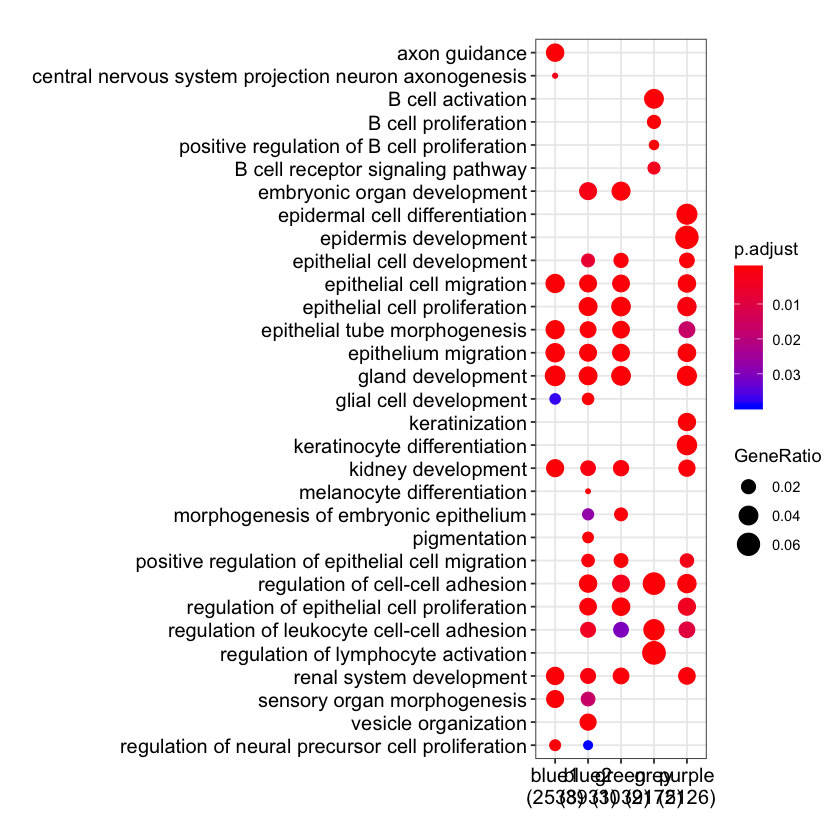

In [36]:
dotplot(ck_go_bp_sel,showCategory = 10)
ggsave(file = paste0(save_prefix, "ck_go_bp_groups_sel.eps"),height=7, width=10)